<a href="https://colab.research.google.com/github/Ajjme/Feedback_Systems/blob/main/Pendulem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np

def cdiff(v, x=None):
    """
    Numerical differentiation of a vector using central differences.

    Parameters:
    - v : ndarray
        Input array (1D or 2D), where differentiation is applied along columns.
    - x : None, float, or ndarray
        - If None: uniform unit spacing is assumed.
        - If float: uniform spacing of dx is used.
        - If ndarray: specifies nonuniform spacing, must match length of v along axis 1.

    Returns:
    - dvdx : ndarray
        Derivative of v with respect to x.
    """
    v = np.atleast_2d(v)
    n = v.shape[1]

    # Determine dx
    if x is None:
        dx = 1.0
    elif np.isscalar(x):
        dx = x
    else:
        x = np.asarray(x)
        if x.shape[0] != n:
            raise ValueError("Length of x must match the number of columns in v")
        dx = np.empty_like(x)
        dx[0] = x[1] - x[0]
        dx[1:-1] = 0.5 * (x[2:] - x[:-2])
        dx[-1] = x[-1] - x[-2]

    # Calculate finite differences
    dv = np.empty_like(v)
    dv[:, 0] = v[:, 1] - v[:, 0]                      # forward difference
    dv[:, 1:-1] = 0.5 * (v[:, 2:] - v[:, :-2])        # central difference
    dv[:, -1] = v[:, -1] - v[:, -2]                   # backward difference

    # Divide by dx
    if np.isscalar(dx):
        dvdx = dv / dx
    else:
        dvdx = dv / dx  # numpy broadcasting

    return dvdx.squeeze()


In [4]:

def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    (it depends on not just time and state but also external inputs (u) and constanstant (c))

    Parameters:
        odefun : function (t, x, u, c) -> (dxdt, y)
            Function that returns state derivative and output.
        time : array-like, shape (p,)
            Time values at which the solution is computed.
        x0 : array-like, shape (n,)
            Initial state at time[0].
        u : array-like, shape (m, p), optional
            System forcing input sampled at each time step.
        c : any
            Optional constants passed to odefun.

    Returns:
        time : ndarray
        x_sol : ndarray, shape (n, p)
        x_drv : ndarray, shape (n, p)
        y_sol : ndarray, shape (m, p)
    """
    time = np.asarray(time)
    x0 = np.asarray(x0).flatten()
    points = len(time) #creates number of time steps

#create defaults if not provided
    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)
#verify inputs recieved are in 2D array shape
    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')


    # Initial output
    #odefun is the user defined derivitive
    # give us np.array(dxdt), np.array([fi]) from the function above
    # dxdt is first deriviative estimate and fi (now y1) is the sliding friction force
    dxdt1, y1 = odefun(time[0], x0, u[:, 0], c)

#set up arrays
    n = x0.size
    m = np.asarray(y1).size

    x_sol = np.full((n, points), np.nan)
    x_drv = np.full((n, points), np.nan)
    y_sol = np.full((m, points), np.nan)

    x_sol[:, 0] = x0 #states
    x_drv[:, 0] = dxdt1 # dervs
    y_sol[:, 0] = y1 # outputs

# time steping loop and main integration
    for p in range(points - 1):
      # get pieces needed for rk4
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

# compute rk4 intermediate dervitives
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt2, x0 + dxdt2 * dt2, u_mid, c)
        dxdt4, _ = odefun(t + dt,  x0 + dxdt3 * dt, u[:, p + 1], c)

# update the state using the intermediate derivities to get a more accurate result than just one derv
        x0 = x0 + (dxdt1 + 2 * (dxdt2 + dxdt3) + dxdt4) * dt / 6.0
# next level
# this gives us the next output from the provided differencial equation
        dxdt1, y1 = odefun(time[p + 1], x0, u[:, p + 1], c)

#than we put it into the array
        x_sol[:, p + 1] = x0 #state
        x_drv[:, p + 1] = dxdt1 #derv
        y_sol[:, p + 1] = y1 #output

#safetly incase NaN or Inf
        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol


In [6]:
# --- Constants ---
cg = 9.81
cm = 1.0
cl = 1.0
ck = 0.2
cc = 0.001
c = [cg, cm, cl, ck, cc]

# --- Time ---
T = 200
dt = 0.01
N = int(T / dt)
t = np.linspace(0, T - dt, N)

# --- Forcing Function u(t) and its Derivatives ---
w = 2 * np.sqrt(cg / cl)
u = 0.2 * cl * np.sin(w * t) * (np.sin(np.pi * t / T) ** 2)
du = cdiff(u, dt)
ddu = cdiff(du, dt)
u_input = ddu[np.newaxis, :]  # reshape to (1, N) for ode4u

# --- Initial State [q, dq, du, u] ---
x0 = [0.01 * 2 * np.pi, 0, 0, 0]

# --- ODE System Function ---
def mathieu_sys(t, x, u, c):
    cg, cm, cl, ck, cc = c
    ddu = u[0]  # external forcing (acceleration of the pin)

    q, dq, du, upos = x

    # Positions
    x1 = cl * np.sin(q)
    x2 = cl * np.cos(q) - cl + upos

    # Velocities
    dx1 = cl * np.cos(q) * dq
    dx2 = -cl * np.sin(q) * dq + du

    # Energies
    T = 0.5 * cm * (dx1**2 + dx2**2)
    V = 0.5 * ck * q**2 - cm * cg * x2

    # ODEs
    ddq = -cm * cl * (cg + ddu) * np.sin(q) - ck * q - cc * dq
    dxdt = [dq, ddq, ddu, du]

    return np.array(dxdt), np.array([T, V])

# --- Run Simulation ---

t_out, x_sol, x_drv, y_sol = ode4u(mathieu_sys, t, x0, u=u_input, c=c)

# --- Extract Results ---
q = x_sol[0]
dq = x_sol[1]
dux = x_sol[2]
ux = x_sol[3]

T_energy = y_sol[0]
V_energy = y_sol[1]

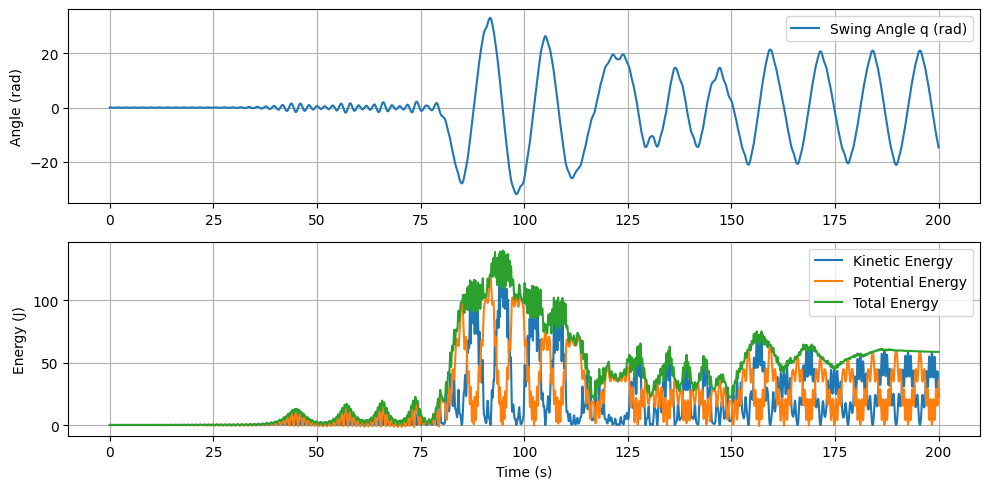

In [8]:
import matplotlib.pyplot as plt
# --- Plotting ---
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(t_out, q, label='Swing Angle q (rad)')
plt.ylabel("Angle (rad)")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_out, T_energy, label='Kinetic Energy')
plt.plot(t_out, V_energy, label='Potential Energy')
plt.plot(t_out, T_energy + V_energy, label='Total Energy')
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

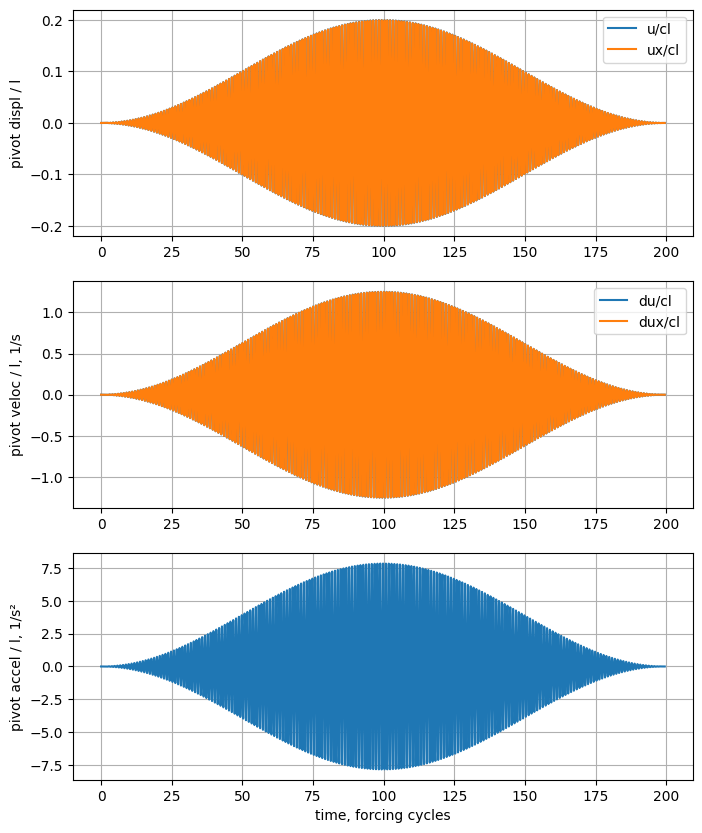

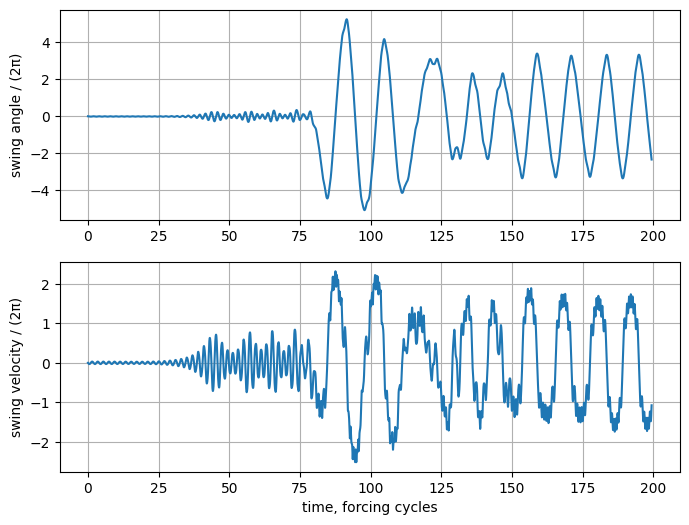

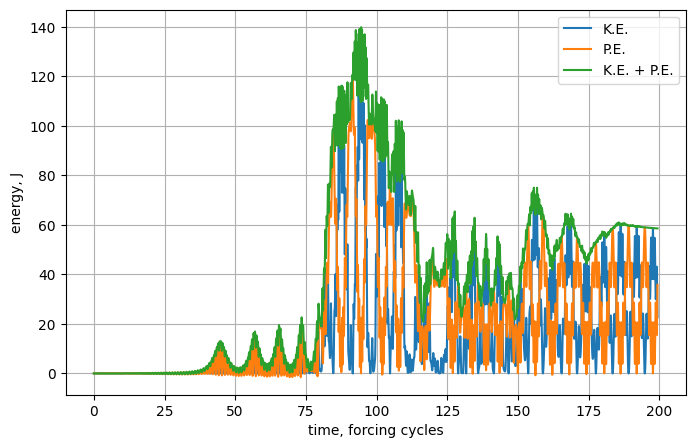

In [9]:
import matplotlib.pyplot as plt

# Normalize time by forcing cycles
forcing_period = 2 * np.pi / w
time_norm = t_out / forcing_period

# Figure 1: Forcing displacement, velocity, acceleration
plt.figure(1, figsize=(8, 10))
plt.clf()

plt.subplot(3, 1, 1)
plt.plot(time_norm, u / cl, label='u/cl')
plt.plot(time_norm, ux / cl, label='ux/cl')
plt.ylabel('pivot displ / l')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_norm, du / cl, label='du/cl')
plt.plot(time_norm, dux / cl, label='dux/cl')
plt.ylabel('pivot veloc / l, 1/s')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time_norm, ddu / cl)
plt.ylabel('pivot accel / l, 1/s²')
plt.xlabel('time, forcing cycles')
plt.grid(True)

# Figure 2: Swing angle response
plt.figure(2, figsize=(8, 6))
plt.clf()

plt.subplot(2, 1, 1)
plt.plot(time_norm, q / (2 * np.pi))
plt.ylabel('swing angle / (2π)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_norm, dq / (2 * np.pi))
plt.ylabel('swing velocity / (2π)')
plt.xlabel('time, forcing cycles')
plt.grid(True)

# Figure 3: Energy
plt.figure(3, figsize=(8, 5))
plt.clf()
plt.plot(time_norm, T_energy, label='K.E.')
plt.plot(time_norm, V_energy, label='P.E.')
plt.plot(time_norm, T_energy + V_energy, label='K.E. + P.E.')
plt.ylabel('energy, J')
plt.xlabel('time, forcing cycles')
plt.legend()
plt.grid(True)

plt.show()
